# Выпускной проект: промышленность

***Заголовок:*** Разработка прогнозных моделей машинного обучения для металлургического комбината «Стальная птица».

***Описание проекта:*** 
Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

***Описание этапа обработки стали***
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


***Описание данных:***
Данные состоят из нескольких файлов, полученных из разных источников:
- data_arc_new.csv;
- data_bulk_new.csv;
- data_bulk_time_new.csv;
- data_gas_new.csv;
- data_temp_new.csv;
- data_wire_new.csv;
- data_wire_time_new.csv.

**Файл data_arc_new.csv** содержит данные об электродах:
- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

**Файл data_bulk_new.csv** содержит данные о подаче сыпучих материалов (объём):
- key — номер партии;
- Bulk 1 … Bulk 15 — объём подаваемого материала.

**Файл data_bulk_time_new.csv** содержит данные о подаче сыпучих материалов (время):
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

**Файл data_gas_new.csv** содержит данные о продувке сплава газом:
- key — номер партии;
- Газ 1 — объём подаваемого газа.

**Файл data_temp_new.csv** содержит результаты измерения температуры:
- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

**Файл data_wire_new.csv** содержит данные о проволочных материалах (объём):
- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

**Файл data_wire_time_new.csv** содержит данные о проволочных материалах (время):
- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Данные также находятся в тренажёре, в папке /datasets/.

***Цель исследования:*** разработать модель машинного обучения, которая поможет металлургическому комбинату «Стальная птица» предсказывать температуру сплава, чтобы уменьшить потребление электроэнергии на этапе обработки стали.

***Ход исследования:***
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Загрузка данных

Загрузим данные и выполним их первичный осмотр.

Сначала установим необходимые библиотеки:

In [1]:
!pip install -q scikit-learn --upgrade

Далее импортируем библиотеки, необходимые для работы:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Считываем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы, сразу загрузим столбцы с датами в формате 'datetime'. Пути к файлам:
- /datasets/data_arc_new.csv - df_arc_new;
- /datasets/data_bulk_new.csv - df_bulk_new;
- /datasets/data_bulk_time_new.csv - df_bulk_time_new;
- /datasets/data_gas_new.csv - df_gas_new;
- /datasets/data_temp_new.csv - df_temp_new;
- /datasets/data_wire_new.csv - df_wire_new;
- /datasets/data_wire_time_new.csv - df_wire_time_new.

In [3]:
df_arc_new = pd.read_csv('/datasets/data_arc_new.csv',
                         parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой']
                        )

df_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

df_bulk_time_new = pd.read_csv(
    '/datasets/data_bulk_time_new.csv',
    parse_dates = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',\
                   'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
)

df_gas_new = pd.read_csv('/datasets/data_gas_new.csv')

df_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates = ['Время замера'])

df_wire_new = pd.read_csv('/datasets/data_wire_new.csv')

df_wire_time_new = pd.read_csv(
    '/datasets/data_wire_time_new.csv',
    parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
)

Проверим, что данные в таблицах соответствуют описанию. Выведем по одной случайной строке всех датафреймов:

In [4]:
df_arc_new.sample(1)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9642,2089,2019-07-26 13:20:49,2019-07-26 13:23:22,0.843035,0.53376


In [5]:
df_bulk_new.sample(1)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2740,2843,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.0,NaN


In [6]:
df_bulk_time_new.sample(1)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2863,2969,2019-08-28 08:33:28,NaT,NaT,2019-08-28 08:57:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-28 08:50:24,NaT,2019-08-28 08:33:28,2019-08-28 08:26:25


In [7]:
df_gas_new.sample(1)

,key,Газ 1
637,640,21.846474


In [8]:
df_temp_new.sample(1)

,key,Время замера,Температура
1459,263,2019-05-13 18:15:51,1599.0


In [9]:
df_wire_new.sample(1)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2070,2168,94.130394,50.125919,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_wire_time_new.sample(1)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1944,2040,2019-07-24 22:43:11,2019-07-24 22:37:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT


***Промежуточный вывод:***

*Таким образом, представленные исходные данные отображаются корректно и соответствуют описанию, а даты выведены в формате 'datetime'.*

## Исследовательский анализ и предобработка данных

### Предобработка данных

Для начала создадим  2 функции: 
- data_main_info, которая будет выводить общую информацию о каждом датафрейме с помощью методов: info() и head();
- data_preprocessing, которая будет определять количество пропущенных значений в каждом столбце и искать явные дубликаты:

In [11]:
def data_main_info(data):
       
    print(f'Общая информация:') 
    print(data.info())
    print()
    print(f'Первые пять строк таблицы:')
    display(data.head())

In [12]:
def data_preprocessing(data):
    print(f'Количество пропущенных значений в каждом столбце:')
    print(data.isna().sum())
    print()   
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')

Рассмотрим общую информацию о каждом датафрейме.

Начнём с данных об электродах:

In [13]:
data_main_info(df_arc_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None

Первые пять строк таблицы:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


В этой таблице присутствует 14876 строк и 5 столбцов. Типы данных во всех столбцах соответствуют содержимому, а названия почти всех столбцов написаны не по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [14]:
data_preprocessing(df_arc_new)

Количество пропущенных значений в каждом столбце:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Количество явных дубликатов: 0


Пропущенные значения и явные дубликаты отсутствуют.

Перейдём к данным об объёмах подачи сыпучих материалов.

In [15]:
data_main_info(df_bulk_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Первые пять строк таблицы:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


В этой таблице имеется 3129 строк и 16 столбцов. Типы данных во всех столбцах соответствуют содержимому, а названия всех столбцов в целом написаны по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [16]:
data_preprocessing(df_bulk_new)

Количество пропущенных значений в каждом столбце:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество явных дубликатов: 0


Явные дубликаты отсутствуют, а в столбцах 'Bulk' имеется большое количество пропусков, которые означают, что то или иное сыпучее вещество не подавалось в данную партию. Значит, заменим эти пропуски на нули:

In [17]:
df_bulk_new = df_bulk_new.fillna(0)

Перейдём к данным о времени подачи сыпучих материалов:

In [18]:
data_main_info(df_bulk_time_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


В этой таблице также имеется 3129 строк и 16 столбцов. Типы данных во всех столбцах соответствуют содержимому, а названия всех столбцов в целом написаны по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [19]:
data_preprocessing(df_bulk_time_new)

Количество пропущенных значений в каждом столбце:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество явных дубликатов: 0


Явные дубликаты отсутствуют, а в столбцах 'Bulk' имеется большое количество пропусков, которые означают, что то или иное сыпучее вещество не подавалось в данную партию. Оставим эти пропуски в таком виде.

Изучим данные о продувке сплава газом:

In [20]:
data_main_info(df_gas_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Первые пять строк таблицы:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


В этой таблице имеется 3239 строк и 2 столбца. Типы данных во всех столбцах соответствуют содержимому, а название столбца с информацией о газе написано не по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [21]:
data_preprocessing(df_gas_new)

Количество пропущенных значений в каждом столбце:
key      0
Газ 1    0
dtype: int64

Количество явных дубликатов: 0


Пропущенные значения и явные дубликаты отсутствуют.

Перейдём к данным о результатах измерения температуры:

In [22]:
data_main_info(df_temp_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
None

Первые пять строк таблицы:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


В этой таблице имеется 18092 строк и 3 столбца. Типы данных во всех столбцах соответствуют содержимому, а названия некоторых стобцов написаны не по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [23]:
data_preprocessing(df_temp_new)

Количество пропущенных значений в каждом столбце:
key                0
Время замера       0
Температура     3427
dtype: int64

Количество явных дубликатов: 0


Явные дубликаты отсутствуют, а в столбце с температурой имеется 3427 пропусков. Удалим эти пропуски:

In [24]:
df_temp_new = df_temp_new.dropna()

Повторно рассмотрим общую информацию и наличие дубликатов и пропущенных значений в данные о температуре:

In [25]:
data_main_info(df_temp_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   Время замера  14665 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB
None

Первые пять строк таблицы:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [26]:
data_preprocessing(df_temp_new)

Количество пропущенных значений в каждом столбце:
key             0
Время замера    0
Температура     0
dtype: int64

Количество явных дубликатов: 0


Теперь в таблице 14665 строк, а пропуски и строки-дубликаты отсутствуют.

Перейдём к изучению данных об объёме проволочных материалов:

In [27]:
data_main_info(df_wire_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Первые пять строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В этой таблице имеется 3081 строка и 10 столбцов. Типы данных во всех столбцах соответствуют содержимому, а названия всех столбцов в целом написаны по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [28]:
data_preprocessing(df_wire_new)

Количество пропущенных значений в каждом столбце:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество явных дубликатов: 0


Явные дубликаты отсутствуют, а в столбцах 'Wire ' имеется большое количество пропусков, которые означают, что тот или иной проволочный материал не подавался в данную партию. Значит, заменим эти пропуски на нули:

In [29]:
df_wire_new = df_wire_new.fillna(0)

Перейдём к данным о времени подачи проволочных материалов:

In [30]:
data_main_info(df_wire_time_new)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
None

Первые пять строк таблицы:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


В этой таблице также имеется 3081 строка и 10 столбцов. Типы данных во всех столбцах соответствуют содержимому, а названия всех столбцов в целом написаны по правилам синтаксиса.

Проверим данные на наличие пропусков и дубликатов:

In [31]:
data_preprocessing(df_wire_time_new)

Количество пропущенных значений в каждом столбце:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество явных дубликатов: 0


Явные дубликаты отсутствуют, а в столбцах 'Wire ' имеется большое количество пропусков, которые означают, что тот или иной проволочный материал не подавался в данную партию. Оставим эти пропуски в таком виде.

Переименуем в датафреймах те столбцы, которые написаны не по правилам синтаксиса:

In [32]:
df_arc_new = df_arc_new.rename(columns={
    'Начало нагрева дугой': 'arc_heat_start',
    'Конец нагрева дугой': 'arc_heat_finish',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

df_bulk_new = df_bulk_new.rename(columns={
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'
})

df_bulk_time_new = df_bulk_time_new.rename(columns={
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15'
})

df_gas_new = df_gas_new.rename(columns={'Газ 1': 'gas_1'})

df_temp_new = df_temp_new.rename(columns={
    'Время замера': 'measure_time',
    'Температура': 'temperature'
})

df_wire_new = df_wire_new.rename(columns={
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9'
})

df_wire_time_new = df_wire_time_new.rename(columns={
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9'
})

***Промежуточный вывод по предобработке данных:***

*Таким образом, в результате предобработки данных в датафреймах:* 
- названия некоторых столбцов в датафреймах были приведены в соответствие правилам синтаксиса;
- пропущенные значения в основном были заменены на нули, а в данных о результатах измерения температуры были удалены;
- явные дубликаты отсутствовали;
- в датафрейм df_arc_new были добавлены два новых столбца с временем нагрева и полной мощностью.

### Исследовательский анализ

Начнём с данных об электродах. Посмотрим сначала общую информацию о распределении данные в столбцах:

In [33]:
df_arc_new.describe(include='all')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-05-26 01:40:30,2019-05-23 10:08:42,NaN,NaN
freq,NaN,1,1,NaN,NaN
first,NaN,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN
last,NaN,2019-09-06 17:24:54,2019-09-06 17:26:15,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175


Как можно видеть, во всех столбцах средние и медианные значения различаются, что говорит о несимметричном распределении данных в них, что будет проверено в дальнейшем.

Кроме того, видно, что реактивная мощность имеет сильно отрицательное минимальное значение, которое не имеет физического смысла. Посмотрим, сколько вообще отрицательных значений реактивной мощности присутствует в данных:

In [34]:
df_arc_new.query('reactive_power < 0')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Такое значение только одно. Изучим другие данные об этой партии:

In [35]:
df_arc_new.query('key == 2116')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Остальные значения реактивной мощности для этой партии адекватны. Создадим столбец с отношением реактивной мощности к активной  и вычислим среднее значение этого отношение без учёта аномалии:

In [36]:
df_arc_new['react_to_act_power'] = df_arc_new['reactive_power'] / df_arc_new['active_power']

df_arc_new.query('key == 2116')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power,react_to_act_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881,0.881064
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498,0.709158
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924,-1014.370185
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513,0.724775


In [37]:
df_arc_new.loc[df_arc_new['reactive_power'] > 0]['react_to_act_power'].mean()

0.7349235684961124

Подставим это значение вместо отрицательного значения в соответствующей строке и домножим на активную мощность:

In [38]:
df_arc_new.loc[df_arc_new['reactive_power'] < 0, 'reactive_power'] = \
df_arc_new.loc[df_arc_new['reactive_power'] > 0]['react_to_act_power'].mean() \
* df_arc_new.loc[df_arc_new['reactive_power'] < 0]['active_power']

Проверим, что получилось:

In [39]:
df_arc_new.query('key == 2116')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power,react_to_act_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881,0.881064
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498,0.709158
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,0.518374,-1014.370185
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513,0.724775


Получили адекватное значение реактивной мощности.

In [40]:
df_arc_new.describe(include='all')

,key,arc_heat_start,arc_heat_finish,active_power,reactive_power,react_to_act_power
count,14876.000000,14876,14876,14876.000000,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN,NaN
top,NaN,2019-05-26 01:40:30,2019-05-23 10:08:42,NaN,NaN,NaN
freq,NaN,1,1,NaN,NaN,NaN
first,NaN,2019-05-03 11:02:14,2019-05-03 11:06:02,NaN,NaN,NaN
last,NaN,2019-09-06 17:24:54,2019-09-06 17:26:15,NaN,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.487118,0.666686
std,934.571502,NaN,NaN,0.258885,0.197606,8.323086
min,1.000000,NaN,NaN,0.223120,0.153777,-1014.370185
25%,806.000000,NaN,NaN,0.467115,0.337192,0.679707


Рассмотрим теперь каждый столбец в отдельности. Начнём со столбца 'key': 

In [41]:
df_arc_new['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

В данных об электродах имеется 3214 уникальных номеров партий, при этом некоторые партия повторяются более одного раза, что говорит о разных итерациях обработки.

Кроме того, как видно из таблицы, вызванной методом describe(), у нас имеются данные об электродах с 3 мая 2019 года по 6 сентября 2019 года, т.е. за 4 месяца.

Имея времена начала и окончания нагрева электродов, можно рассчитать время нагрева. Добавим в датафрейм столбец с временем нагрева в секундах:

In [42]:
df_arc_new['arc_heat_time'] = (df_arc_new['arc_heat_finish'] - df_arc_new['arc_heat_start'])\
.astype('timedelta64[s]')

In [43]:
df_arc_new['arc_heat_time'].describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: arc_heat_time, dtype: float64

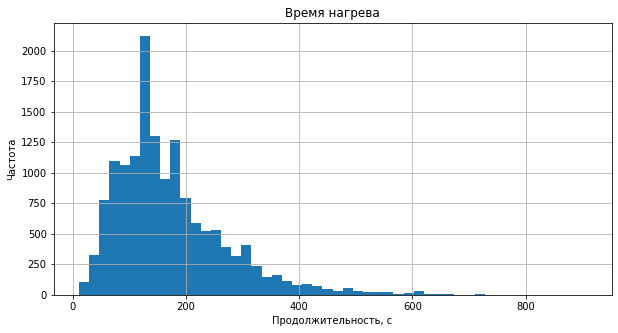

In [44]:
plt.figure(figsize=(10, 5))

df_arc_new['arc_heat_time'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Время нагрева')
plt.xlabel("Продолжительность, с")
plt.ylabel("Частота")
plt.show();

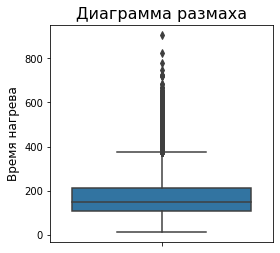

In [45]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_new,y='arc_heat_time');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Время нагрева", fontsize=12);

Время нагрева распределено в общем нормально со смещением влево, в области высоких значений имеются выбросы. Видно также, что оно варьируется от 11 секунд до 15 минут 7 секунд, при этом 75 % измерений имеют значение не более 3,5 минут.

Перейдём к столбцам 'active_power' и 'reactive_power': построим гистограммы и диаграммы размаха:

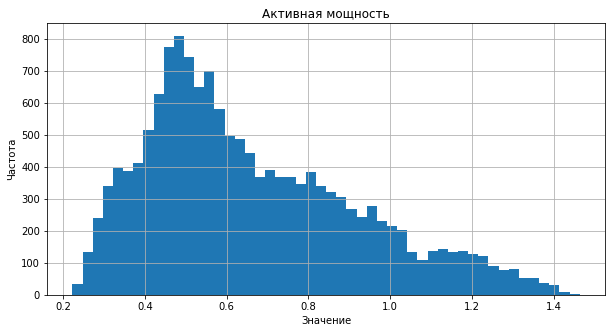

In [46]:
plt.figure(figsize=(10, 5))

df_arc_new['active_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Активная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

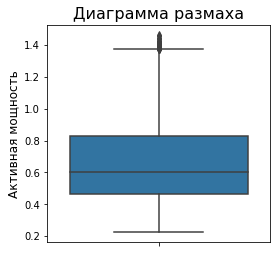

In [47]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_new,y='active_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Активная мощность", fontsize=12);

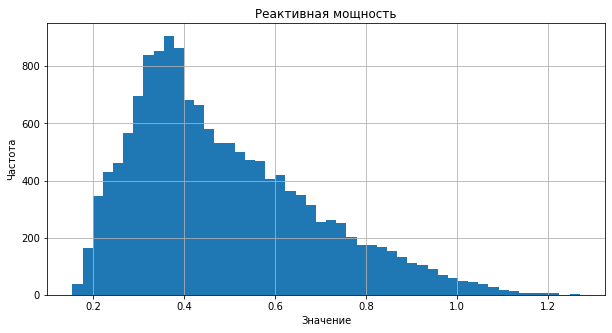

In [48]:
plt.figure(figsize=(10, 5))

df_arc_new['reactive_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Реактивная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

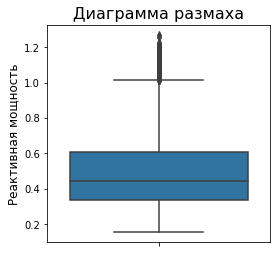

In [49]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_new,y='reactive_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Реактивная мощность", fontsize=12);

Известно, что активная и реактивная мощность связаны через полную мощность следующим образом: полная мощность равна квадратному корню из суммы квадратов активной и реактивной мощностей.

В соответствии с этим добавим столбец с полной мощностью 'full_power' в датафрейм: 

In [50]:
df_arc_new['full_power'] = (df_arc_new['active_power']**2 + df_arc_new['reactive_power']**2)**0.5

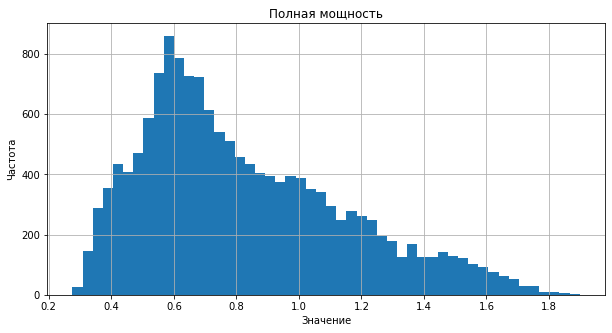

In [51]:
plt.figure(figsize=(10, 5))

df_arc_new['full_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Полная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

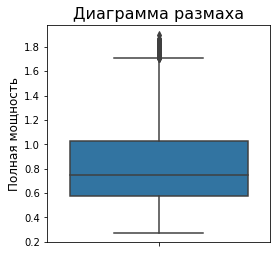

In [52]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_new,y='full_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Полная мощность", fontsize=12);

Как можно видеть, распределения данных по мощностям в целом имеют нормальный вид со смещением влево. Выбросы имеются в области высоких значений, однако из гистограмм видно, что их доля незначительна, поэтому оставим их.

Как было показано, в данных об электродах номера некоторых партий встречаются неоднократно. Сгруппируем данные по 'key', сделав его индексом, и применим к некоторым столбцам агрегирующие функции:
- arc_heat_start - время начала нагрева для каждой партии с учётом итераций;
- arc_heat_finish - время окончания нагрева для каждой партии с учётом итераций;
- sum_arc_heat_time - общее время нагрева для каждой партии с учётом итераций;
- avg_act_power - средняя активная мощность для каждой партии с учётом итераций;
- avg_react_power - средняя реактивная мощность для каждой партии с учётом итераций;
- avg_full_power - средння полная мощность для каждой партии с учётом итераций.

In [53]:
df_arc_agg = df_arc_new.groupby('key')\
.agg({'arc_heat_time':'sum', 
      'active_power':'mean', 
      'reactive_power': 'mean', 
      'full_power': 'mean'})\
.rename(columns={'arc_heat_time':'sum_arc_heat_time',
                 'active_power':'avg_act_power',
                 'reactive_power':'avg_react_power',
                 'full_power':'avg_full_power'})
                              
df_arc_agg.head()

,sum_arc_heat_time,avg_act_power,avg_react_power,avg_full_power
key,,,,
1,1098.0,0.607346,0.428564,0.743747
2,811.0,0.534852,0.363339,0.647087
3,655.0,0.812728,0.587491,1.003845
4,741.0,0.676622,0.514248,0.850010
5,869.0,0.563238,0.421998,0.704245


В итоге мы получили таблицу с данными об электродах, в которой для каждой партии есть агрегированные данные. Исследуем полученные столбцы:

In [54]:
df_arc_agg.describe(include='all')

,sum_arc_heat_time,avg_act_power,avg_react_power,avg_full_power
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.579029,0.661331,0.485973,0.821568
std,332.448622,0.128372,0.097586,0.160110
min,57.000000,0.267676,0.196228,0.331897
25%,571.000000,0.573035,0.417415,0.711251
50%,770.000000,0.652974,0.481639,0.812409
75%,983.000000,0.739388,0.543312,0.916602
max,4189.000000,1.243889,0.960763,1.572238


Как можно видеть, средние и медианные значения для суммарного времени нагрева различаются, а вот у показателей мощности они близки, убедимся в этом, построив гистограммы и диаграммы размаха для каждого столбца.

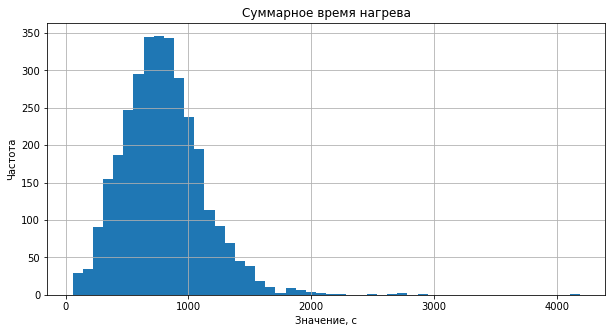

In [55]:
plt.figure(figsize=(10, 5))

df_arc_agg['sum_arc_heat_time'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Суммарное время нагрева')
plt.xlabel("Значение, с")
plt.ylabel("Частота")
plt.show();

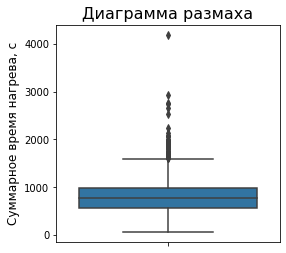

In [56]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_agg,y='sum_arc_heat_time');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Суммарное время нагрева, с", fontsize=12);

Общее время нагрева электродов имеет вид нормального распределения, однако в области высоких значений присутствуют выбросы. Оставим их.

Теперь изучим гистограммы и диаграммы размаха для средних значений активной, реактивной и полной мощностей:

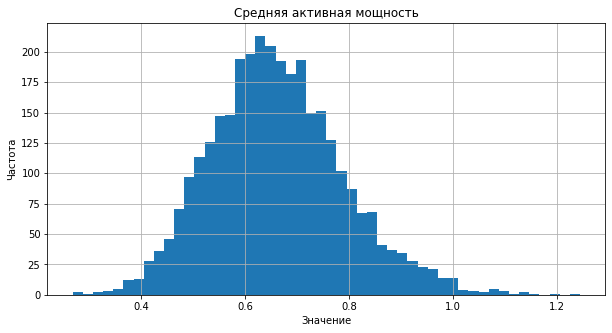

In [57]:
plt.figure(figsize=(10, 5))

df_arc_agg['avg_act_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Средняя активная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

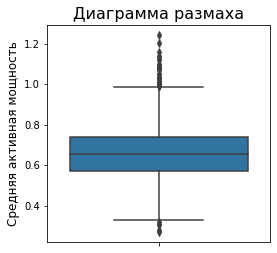

In [58]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_agg,y='avg_act_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Средняя активная мощность", fontsize=12);

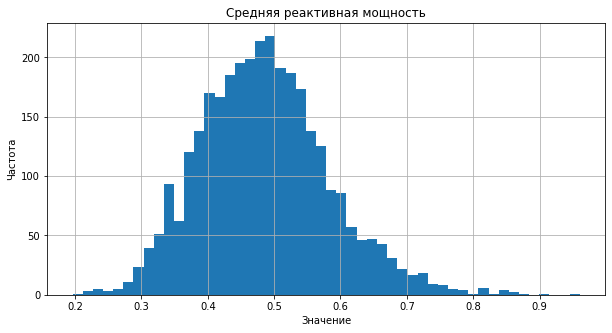

In [59]:
plt.figure(figsize=(10, 5))

df_arc_agg['avg_react_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Средняя реактивная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

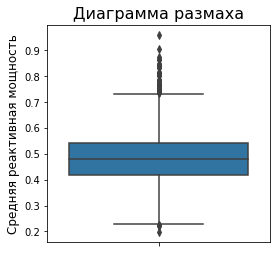

In [60]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_agg,y='avg_react_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Средняя реактивная мощность", fontsize=12);

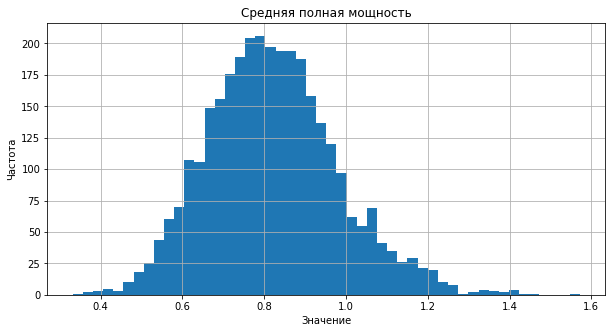

In [61]:
plt.figure(figsize=(10, 5))

df_arc_agg['avg_full_power'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Средняя полная мощность')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

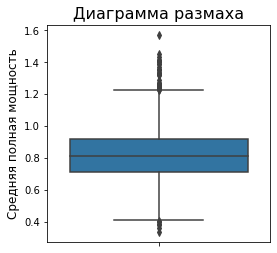

In [62]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_arc_agg,y='avg_full_power');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Средняя полная мощность", fontsize=12);

Как можно видеть, распределения данных по мощностям меют нормальный вид. Выбросы имеются в области высоких значений.

Перейдём к изучению данных о подаче сыпучих материалов:

In [63]:
df_bulk_new.describe(include='all')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Объёмы подачи сыпучих веществ носят дискретный характер: для каждой партии подаётся определённый объём лишь нескольких соединений (в основном Bulk 3. Bulk 4, Bulk 12, Bulk 14, Bulk 15).

Посмотрим, сколько раз каждая партия присутствует в этой таблице:

In [64]:
df_bulk_new['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

Всего здесь 3129 уникальных номеров партий, каждая из которых встречается лишь единожды.

Сделаем столбец 'key' индексами таблицы:

In [65]:
df_bulk_new = df_bulk_new.set_index('key')

Добавим в таблицу новый столбец с общим объёмом добавленных сыпучих веществ в каждую партию:

In [66]:
df_bulk_new['sum_bulk'] = df_bulk_new.sum(axis=1)

df_bulk_new.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk
key,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


Построим диаграмму размаха для всего датафрейма:

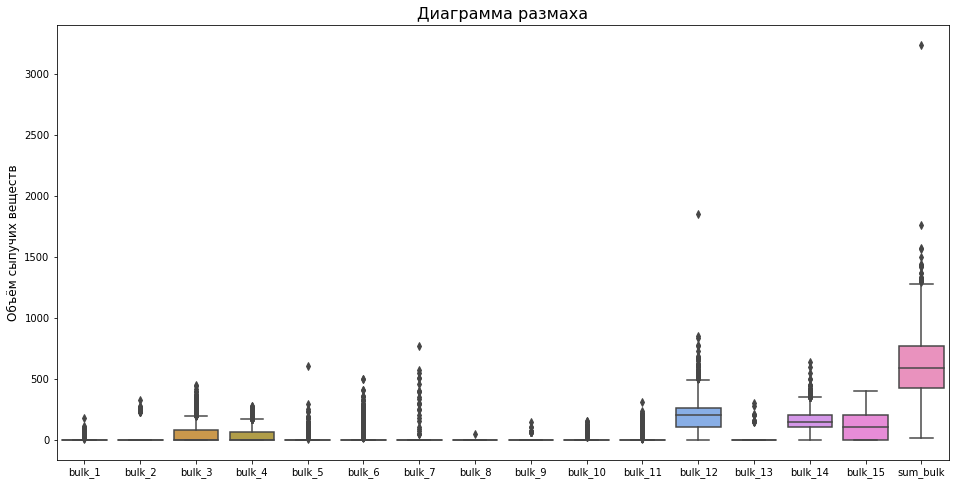

In [67]:
plt.figure(figsize=(16,8));

sns.boxplot(data=df_bulk_new);

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём сыпучих веществ", fontsize=12);

Для всех типов сыпучих веществ имеются выбросы в области высоких значений. Оставим их.

Как распределён общий объём подаваемых сыпучих веществ:

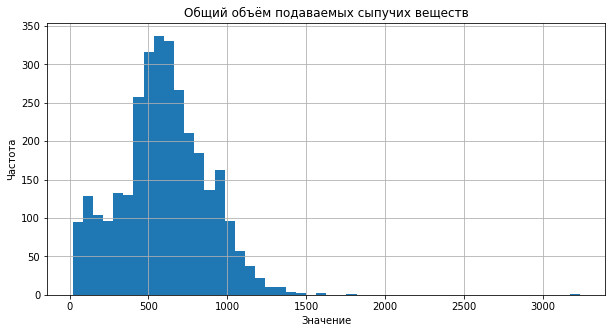

In [68]:
plt.figure(figsize=(10, 5))

df_bulk_new['sum_bulk'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Общий объём подаваемых сыпучих веществ')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

Общий объём сыпучих веществ в первом приближении имеет вид нормального распределения, хотя и наблюдаются локальные максимумы, искажающие общий куполообразный вид распределения.

Далее исследуем данные о времени подачи сыпучих веществ:

In [69]:
df_bulk_time_new.describe(include='all')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-06-11 08:44:22,2019-05-07 19:13:07,2019-07-29 20:53:23,2019-08-13 11:29:34,2019-08-13 08:05:11,2019-08-11 22:51:04,2019-05-15 22:42:51,2019-07-08 17:14:53,2019-08-16 06:07:48,2019-05-17 22:17:26,2019-08-18 05:07:43,2019-07-11 05:44:13,2019-06-09 08:18:22,2019-05-03 11:14:50,2019-06-21 12:56:46
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
first,NaN,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
last,NaN,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим, сколько раз каждая партия присутствует в этой таблице:

In [70]:
df_bulk_time_new['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

Также имеется 3129 номеров партий, встречающихся по одному разу.

Аналогичным образом преобразуем этот столбец в индексы:

In [71]:
df_bulk_time_new = df_bulk_time_new.set_index('key')

Создадим в таблице новые столбцы с началом добавления сыпучих веществ, с концом добавления сыпучих веществ и с общим временем добавления сыпучих веществ в каждую партию:

In [72]:
df_bulk_time_new['bulk_start'] = df_bulk_time_new.min(axis=1)
df_bulk_time_new['bulk_finish'] = df_bulk_time_new.max(axis=1)
df_bulk_time_new['bulk_time'] = (df_bulk_time_new.max(axis=1) - df_bulk_time_new.min(axis=1)).astype('timedelta64[s]')

df_bulk_time_new.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_start,bulk_finish,bulk_time
key,,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:10:43,2019-05-03 11:28:48,1085.0
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,2019-05-03 11:53:30,1000.0
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:16:16,2019-05-03 12:32:39,983.0
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,2019-05-03 12:58:00,878.0
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,205.0


In [73]:
df_bulk_time_new.describe(include='all')

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_start,bulk_finish,bulk_time
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248,3129,3129,3129.000000
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248,3129,3129,NaN
top,2019-06-11 08:44:22,2019-05-07 19:13:07,2019-07-29 20:53:23,2019-08-13 11:29:34,2019-08-13 08:05:11,2019-08-11 22:51:04,2019-05-15 22:42:51,2019-07-08 17:14:53,2019-08-16 06:07:48,2019-05-17 22:17:26,2019-08-18 05:07:43,2019-07-11 05:44:13,2019-06-09 08:18:22,2019-05-03 11:14:50,2019-06-21 12:56:46,2019-07-04 10:16:10,2019-08-28 20:35:53,NaN
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NaN
first,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:10:43,2019-05-03 11:28:48,NaN
last,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15,2019-09-06 17:23:15,2019-09-06 17:26:33,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,964.906679
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.088025
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,485.000000


Изучим столбец с общим временем добавления сыпучих веществ:

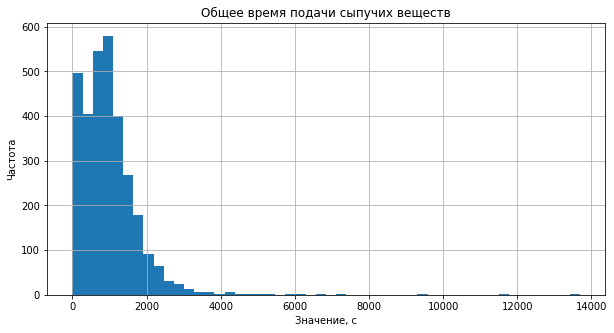

In [74]:
plt.figure(figsize=(10, 5))

df_bulk_time_new['bulk_time'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Общее время подачи сыпучих веществ')
plt.xlabel("Значение, с")
plt.ylabel("Частота")
plt.show();

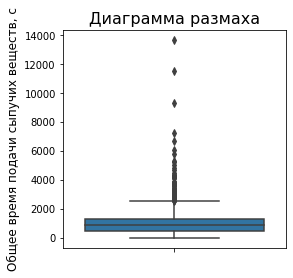

In [75]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_bulk_time_new, y='bulk_time');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Общее время подачи сыпучих веществ, с", fontsize=12);

В целом общее время подачи сыпучих веществ имеет вид нормального распределения, однако у нас присутствуют в большом количестве нулевые значения. Сначала посчитаем их: 

In [76]:
df_bulk_time_new.query('bulk_time == 0')

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_start,bulk_finish,bulk_time
key,,,,,,,,,,,,,,,,,,
16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 22:33:22,NaT,2019-05-03 22:33:22,2019-05-03 22:33:22,2019-05-03 22:33:22,2019-05-03 22:33:22,0.0
19,NaT,NaT,NaT,NaT,NaT,2019-05-04 01:14:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 01:14:08,2019-05-04 01:14:08,0.0
20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 02:14:31,NaT,2019-05-04 02:14:31,2019-05-04 02:14:31,0.0
26,NaT,NaT,2019-05-04 08:46:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 08:46:22,2019-05-04 08:46:22,0.0
48,NaT,NaT,NaT,NaT,NaT,2019-05-05 08:08:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-05 08:08:36,2019-05-05 08:08:36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 16:39:32,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 16:39:32,2019-09-05 16:39:32,0.0
3214,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 18:40:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 18:40:50,2019-09-05 18:40:50,0.0
3215,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 19:07:49,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-05 19:07:49,2019-09-05 19:07:49,0.0


Нулевых значений общего времени - 357, это могут быть выбросы, а можно предположить, что нули в данном случае означают одновременную загрузку сыпучих материалов к стали. Будем полагать так.

Перейдём к рассмотрению данных об объёме подаваемого газа:

In [77]:
df_gas_new.describe(include='all')

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Как можно видеть, средние и медианные значения различаются в столбце 'gas_1', что говорит о несимметричном распределении данных.

Начнём снова со столбца 'key':

In [78]:
df_gas_new['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

Число партий в этом датафрейме составляет 3239, вновь каждая партия встречается лишь один раз.

Преобразуем этот столбец в индексы:

In [79]:
df_gas_new = df_gas_new.set_index('key')

Построим гистограмму и диаграмму размаха для столбца 'gas_1':

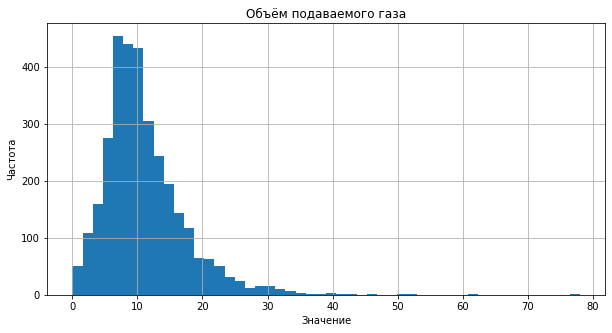

In [80]:
plt.figure(figsize=(10, 5))

df_gas_new['gas_1'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Объём подаваемого газа')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

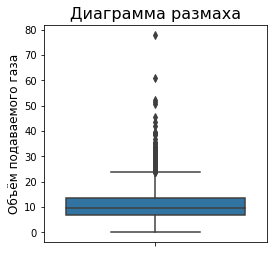

In [81]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_gas_new,y='gas_1');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём подаваемого газа", fontsize=12);

Как можно видеть, распределение объёма подаваемого газа носит нормальный характер, однако в области высоких значений имеются выбросы. Оставим их.

Далее исследуем данные о результатах измерения температуры:

In [82]:
df_temp_new.describe(include='all')

,key,measure_time,temperature
count,14665.000000,14665,14665.000000
unique,NaN,14665,NaN
top,NaN,2019-06-30 07:04:18,NaN
freq,NaN,1,NaN
first,NaN,2019-05-03 11:02:04,NaN
last,NaN,2019-09-06 16:48:55,NaN
mean,1325.484214,NaN,1590.722741
std,787.375969,NaN,20.394381
min,1.000000,NaN,1191.000000
25%,654.000000,NaN,1580.000000


Как можно видеть, средние и медианные значения почти не различаются в столбце 'temperature', что говорит о симметричном распределении данных.

Вновь сначала посмотрим на столбец с номером партии:

In [83]:
df_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
322     14
46      14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3216, dtype: int64

Число партий в этом датафрейме составляет 3216, при этом некоторые партия повторяются более одного раза, что говорит о разных итерациях обработки.

Построим гистограмму и диаграмму размаха для столбца 'temperature':

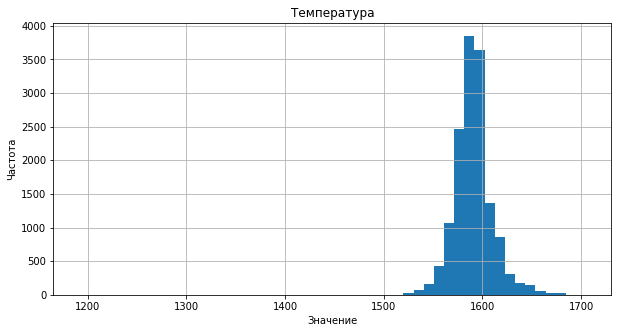

In [84]:
plt.figure(figsize=(10, 5))

df_temp_new['temperature'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Температура')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

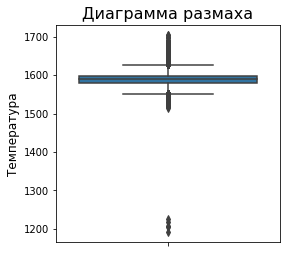

In [85]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_temp_new,y='temperature');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Температура", fontsize=12);

Распределение измеренной температуры имеет нормальный вид. Однако имеются выбросы как в области малых, так и в области высоких температур.

При этом необходимо отметить, что температура плавления стали находится в промежутке от 1350 до 1535 градусов Цельсия. Посмотрим, сколько значений температуры ниже 1350 градусов:

In [86]:
df_temp_new.query('temperature < 1350')['temperature'].count()

5

Всего 5 значений не удовлетворяют температурному режиму плавления стали. Удалим их из датафрейма:

In [87]:
df_temp_new = df_temp_new.query('temperature >= 1350')

Изучим обновлённый столбец 'temperature':

In [88]:
df_temp_new.describe(include='all')

,key,measure_time,temperature
count,14660.000000,14660,14660.000000
unique,NaN,14660,NaN
top,NaN,2019-06-30 07:04:18,NaN
freq,NaN,1,NaN
first,NaN,2019-05-03 11:02:04,NaN
last,NaN,2019-09-06 16:48:55,NaN
mean,1325.369236,NaN,1590.852729
std,787.407873,NaN,19.143141
min,1.000000,NaN,1515.000000
25%,654.000000,NaN,1580.000000


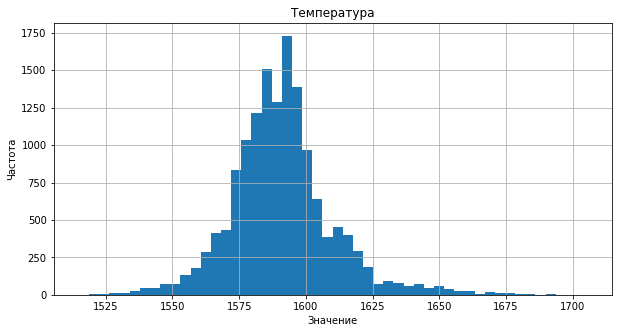

In [89]:
plt.figure(figsize=(10, 5))

df_temp_new['temperature'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Температура')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

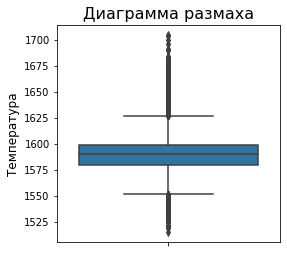

In [90]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_temp_new,y='temperature');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Температура", fontsize=12);

Средние и медианные значения практически сравнялись и находятся на уровне 1590 градусов Цельсия. Минимальная температура теперь находится на уровне 1515 градусов, что укладывается в температурный диапазон плавления стали.

Выбросы по обе стороны от основной массы значений всё равно остались, посмотрим их долю: 

In [91]:
df_temp_new.query('temperature <= 1550 | temperature >=1625')['temperature'].count() / len(df_temp_new) * 100

6.064120054570259

Около 6.1 % значений являются выбросами, оставим их.

Как было показано, в данных о температурах номера некоторых партий встречаются неоднократно. Сгруппируем данные по 'key', сделав его индексом, и применим к некоторым столбцам агрегирующие функции:
- first_meas_time - время первого измерения температуры для каждой партии;
- last_meas_time - время последнего измерения температуры для каждой партии;
- first_temp - первое измерение температуры для каждой партии;
- last_temp - последнее измерение температуры для каждой партии.

**Именно последнее измерение температуры и является целевым признаком в данной задаче!**

In [92]:
df_temp_agg = df_temp_new.groupby('key')\
.agg({'measure_time':['first','last'], 
      'temperature':['first', 'last']})
                              
df_temp_agg.columns = ['first_meas_time', 'last_meas_time', 'first_temp', 'last_temp']

df_temp_agg.head()

,first_meas_time,last_meas_time,first_temp,last_temp
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [93]:
# КОД МЕНТОРА
df_temp_agg

,first_meas_time,last_meas_time,first_temp,last_temp
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0


У нас есть партии, в которых первая и последняя температуры совпадают. Значит, у таких партий либо только одна температура, т.е. первая, либо температуры начала и конца в таких партиях совпадают. Посмотрим на партии, у которых только одна температура:

In [94]:
df_temp_agg.query('first_temp == last_temp & first_meas_time == last_meas_time')

,first_meas_time,last_meas_time,first_temp,last_temp
key,,,,
195,2019-05-11 00:01:36,2019-05-11 00:01:36,1583.0,1583.0
279,2019-05-14 10:13:01,2019-05-14 10:13:01,1603.0,1603.0
2500,2019-08-10 14:04:39,2019-08-10 14:04:39,1539.0,1539.0
2501,2019-08-10 14:41:14,2019-08-10 14:41:14,1587.0,1587.0
2502,2019-08-10 15:39:39,2019-08-10 15:39:39,1583.0,1583.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0


740 партий имеют только одну измеренную температуру, а нам нужно определять конечную температуру, поэтому удалим такие партии из рассмотрения:

In [95]:
df_temp_agg = df_temp_agg.query('first_meas_time != last_meas_time')

In [96]:
df_temp_agg.describe(include='all')

,first_meas_time,last_meas_time,first_temp,last_temp
count,2475,2475,2475.000000,2475.000000
unique,2475,2475,NaN,NaN
top,2019-06-07 17:26:11,2019-05-07 01:59:09,NaN,NaN
freq,1,1,NaN,NaN
first,2019-05-03 11:02:04,2019-05-03 11:30:38,NaN,NaN
last,2019-08-10 13:33:21,2019-08-10 13:58:58,NaN,NaN
mean,NaN,NaN,1589.029899,1595.336162
std,NaN,NaN,24.998058,16.023153
min,NaN,NaN,1519.000000,1541.000000
25%,NaN,NaN,1572.000000,1587.000000


Как можно видеть, средние и медианные значения для температур довольно близки. Построим гистограммы и диаграммы размаха для каждого столбца.

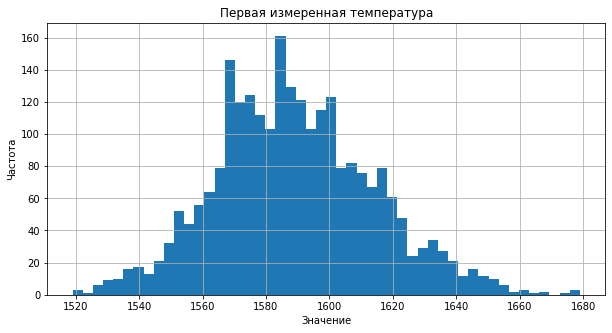

In [97]:
plt.figure(figsize=(10, 5))

df_temp_agg['first_temp'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Первая измеренная температура')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

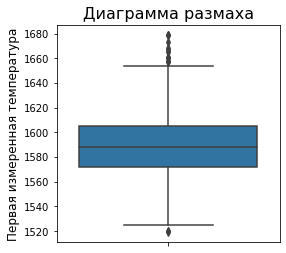

In [98]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_temp_agg,y='first_temp');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Первая измеренная температура", fontsize=12);

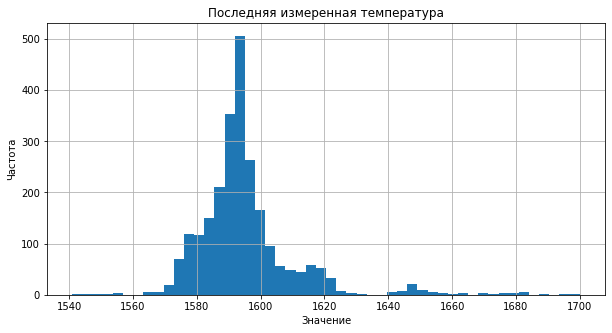

In [99]:
plt.figure(figsize=(10, 5))

df_temp_agg['last_temp'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Последняя измеренная температура')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

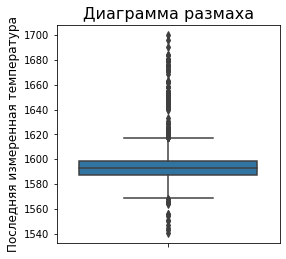

In [100]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_temp_agg,y='last_temp');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Последняя измеренная температура", fontsize=12);

Средние и медианные значения практически одинаковы, несмотря на наличие выбросов по обе стороны от основной массы измеренных температур.

Нам осталось исследовать данные о проволочных материалах. 

In [101]:
df_wire_new.describe(include='all')

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Объёмы подачи проволочных веществ носят дискретный характер: для каждой партии подаётся определённый объём лишь нескольких соединений (в основном Wire 1 и Wire 2).

Посмотрим, сколько раз каждая партия присутствует в этой таблице:

In [102]:
df_wire_new['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Всего здесь 3081 уникальных номеров партий, каждая из которых встречается лишь единожды.

Преобразуем этот столбец в индексы:

In [103]:
df_wire_new = df_wire_new.set_index('key')

Добавим в таблицу новый столбец с общим объёмом добавленных проволочных материалов в каждую партию:

In [104]:
df_wire_new['sum_wire'] = df_wire_new.sum(axis=1)

df_wire_new.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
key,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Построим диаграмму размаха для всего датафрейма:

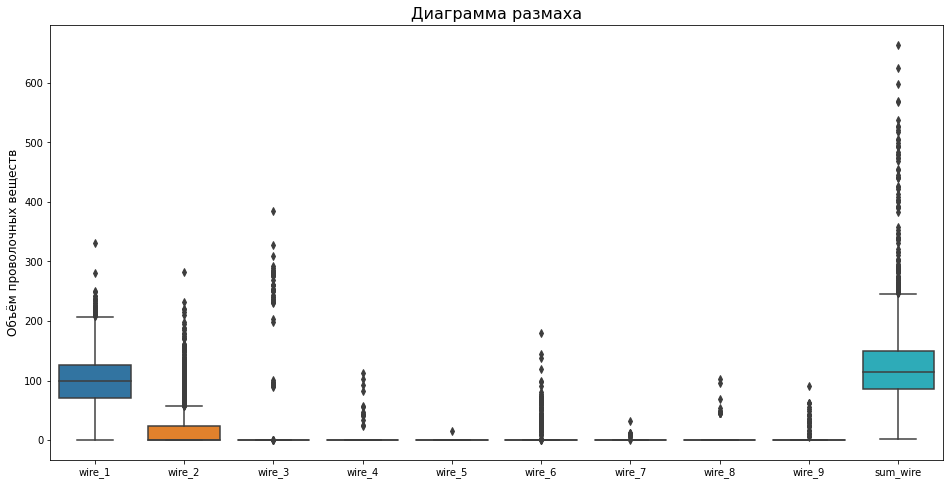

In [105]:
plt.figure(figsize=(16,8));

sns.boxplot(data=df_wire_new);

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Объём проволочных веществ", fontsize=12);

Для всех типов проволочных материалов имеются выбросы в области высоких значений.

Как распределён общий объём проволочных веществ:

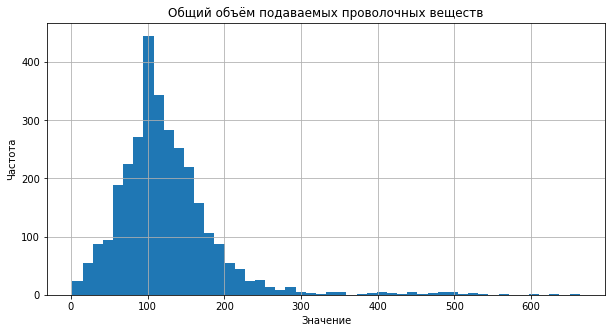

In [106]:
plt.figure(figsize=(10, 5))

df_wire_new['sum_wire'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Общий объём подаваемых проволочных веществ')
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show();

Распределение имеет нормальный вид, несмотря на выбросы.

Далее исследуем данные о времени подачи проволочных материалов:

In [107]:
df_wire_time_new.describe(include='all')

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-05-25 04:54:17,2019-07-10 12:38:23,2019-07-11 18:01:03,2019-08-12 19:51:09,2019-08-13 06:14:30,2019-05-09 02:52:53,2019-08-13 01:13:45,2019-07-08 16:56:51,2019-06-09 19:55:31
freq,NaN,1,1,1,1,1,1,1,1,1
first,NaN,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
last,NaN,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим, сколько раз каждая партия присутствует в этой таблице:

In [108]:
df_wire_time_new['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

Также имеется 3081 номеров партий, встречающихся по одному разу.

Аналогичным образом преобразуем этот столбец в индексы:

In [109]:
df_wire_time_new = df_wire_time_new.set_index('key')

Создадим в таблице новые столбцы с началом добавления проволочных веществ, с концом добавления проволочных веществ и с общим временем добавления проволочных веществ в каждую партию:

In [110]:
df_wire_time_new['wire_start'] = df_wire_time_new.min(axis=1)
df_wire_time_new['wire_finish'] = df_wire_time_new.max(axis=1)
df_wire_time_new['wire_time'] = (df_wire_time_new.max(axis=1) - df_wire_time_new.min(axis=1))\
.astype('timedelta64[s]')

df_wire_time_new.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_start,wire_finish,wire_time
key,,,,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0


In [111]:
df_wire_time_new.describe(include='all')

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_start,wire_finish,wire_time
count,3055,1079,63,14,1,73,11,19,29,3081,3081,3081.000000
unique,3055,1079,63,14,1,73,11,19,29,3081,3081,NaN
top,2019-05-25 04:54:17,2019-07-10 12:38:23,2019-07-11 18:01:03,2019-08-12 19:51:09,2019-08-13 06:14:30,2019-05-09 02:52:53,2019-08-13 01:13:45,2019-07-08 16:56:51,2019-06-09 19:55:31,2019-08-17 06:50:00,2019-07-28 01:17:01,NaN
freq,1,1,1,1,1,1,1,1,1,1,1,NaN
first,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27,2019-05-03 11:06:19,2019-05-03 11:06:19,NaN
last,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23,2019-09-06 17:10:06,2019-09-06 17:10:06,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.519312
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396.131967
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


Изучим столбец с общим временем добавления проволочных веществ:

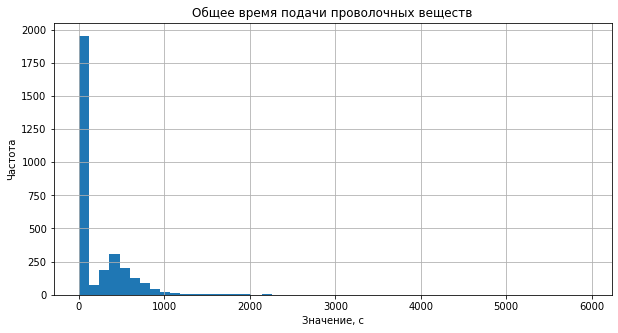

In [112]:
plt.figure(figsize=(10, 5))

df_wire_time_new['wire_time'].hist(
    bins=50,
    grid = True,
    linewidth=3,
)
plt.title('Общее время подачи проволочных веществ')
plt.xlabel("Значение, с")
plt.ylabel("Частота")
plt.show();

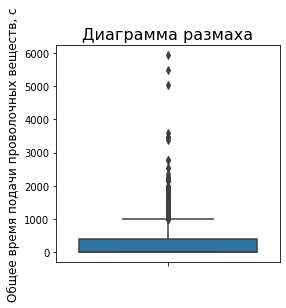

In [113]:
plt.figure(figsize=(4,4));

sns.boxplot(data=df_wire_time_new, y='wire_time');

plt.title("Диаграмма размаха", fontsize=16);
plt.ylabel("Общее время подачи проволочных веществ, с", fontsize=12);

В целом общее время подачи проволочных веществ имеет вид нормального распределения. В области более 1000 имеются выбросы, оставим их.

Также видно, что имеется превалирующее количество нулевых значений. Посчитаем их:

In [114]:
df_wire_time_new.query('wire_time == 0')['wire_time'].count()

1951

Нулевых значений общего времени - 1951, это могут быть выбросы, а можно предположить, что нули в данном случае означают одновременную подачу проволочных материалов к стали. Будем полагать так.

***Промежуточный вывод по исследовательскому анализу:***

*Таким образом,был проведён исследовательский анализ данных, в результате которого было проделано следующее:*
1. Для датафрейма df_arc_new:
- добавили столбцы с временем нагрева и полной мощностью;
- определили нормальный вид распределений;
- сформировали датафрейм с агрегированными данными, сгрупированными по номеру партии;

2. Для датафрейма df_bulk_new:
- добавили столбец с общим объёмом добавленных сыпучих веществ в каждую партию;
- определили в первом приближении нормальный вид распределения;

3. Для датафрейма df_bulk_time_new:
- добавили столбцы с началом добавления, с концом добавления сыпучих веществ и с общим временем добавления сыпучих веществ в каждую партию;
- определили в первом приближении нормальный вид распределения;
- оставили нулевые значения общего времени;

4. Для датафрейма df_gas_new:
- определили нормальный вид распределения;

5. Для датафрейма df_temp_new:
- сформировали правильный диапазон температур;
- определили нормальный вид распределения;
- сформировали датафрейм с агрегированными данными, сгрупированными по номеру партии;

6. Для датафрейма df_wire_new:
- добавили столбец с общим объёмом проволочных веществ;
- определили нормальный вид распределения;

7. Для датафрейма df_wire_time_new:
- добавили столбцы с началом добавления, с концом добавления и с общим временем добавления проволочных веществ в каждую партию;
- - определили в первом приближении нормальный вид распределения;
- оставили нулевые значения общего времени.

Во всех датафреймах столбец с номером партии ('key') был превращен в индексы.

## Объединение данных

Объединим все данные, кроме временных (т.е. df_bulk_time_new и df_wire_time_new), в один датафрейм по ключу с помощью метода merge. Начнём объединение с датафрейма df_temp_agg, поскольку именно здесь находится целевой признак и все индексы этого датафрейма должны присутствовать в общей таблице:

In [115]:
df = df_temp_agg.merge(df_arc_agg, on='key')

df = df.merge(df_bulk_new, on='key')

df = df.merge(df_gas_new, on='key')

df = df.merge(df_wire_new, on='key')

df.head()

,first_meas_time,last_meas_time,first_temp,last_temp,sum_arc_heat_time,avg_act_power,avg_react_power,avg_full_power,bulk_1,bulk_2,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1098.0,0.607346,0.428564,0.743747,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,811.0,0.534852,0.363339,0.647087,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,655.0,0.812728,0.587491,1.003845,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,741.0,0.676622,0.514248,0.850010,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,869.0,0.563238,0.421998,0.704245,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


***Промежуточный вывод:***

*Таким образом, мы объединили по индексам преобразованные и сформированные в ходе исследовательского анализа данные в один датафрейм. Объединению не подвергались временные данные, а именно df_bulk_time_new и df_wire_time_new.*

## Анализ объединённого датафрейма

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку.

Начнём с общей информации о датафрейме:

In [116]:
data_main_info(df)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_meas_time    2329 non-null   datetime64[ns]
 1   last_meas_time     2329 non-null   datetime64[ns]
 2   first_temp         2329 non-null   float64       
 3   last_temp          2329 non-null   float64       
 4   sum_arc_heat_time  2329 non-null   float64       
 5   avg_act_power      2329 non-null   float64       
 6   avg_react_power    2329 non-null   float64       
 7   avg_full_power     2329 non-null   float64       
 8   bulk_1             2329 non-null   float64       
 9   bulk_2             2329 non-null   float64       
 10  bulk_3             2329 non-null   float64       
 11  bulk_4             2329 non-null   float64       
 12  bulk_5             2329 non-null   float64       
 13  bulk_6             2329 non-null   float64   

,first_meas_time,last_meas_time,first_temp,last_temp,sum_arc_heat_time,avg_act_power,avg_react_power,avg_full_power,bulk_1,bulk_2,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1098.0,0.607346,0.428564,0.743747,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,811.0,0.534852,0.363339,0.647087,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,655.0,0.812728,0.587491,1.003845,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,741.0,0.676622,0.514248,0.850010,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,869.0,0.563238,0.421998,0.704245,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


In [117]:
data_preprocessing(df)

Количество пропущенных значений в каждом столбце:
first_meas_time      0
last_meas_time       0
first_temp           0
last_temp            0
sum_arc_heat_time    0
avg_act_power        0
avg_react_power      0
avg_full_power       0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
sum_bulk             0
gas_1                0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
sum_wire             0
dtype: int64

Количество явных дубликатов: 0


В объединённом датафрейме 2329 строк и 35 столбцов. Все типы данных соответствуют содержимому, а пропущенные значения и строки-дубликаты отсутствуют.

Проведём корреляционный анализ:

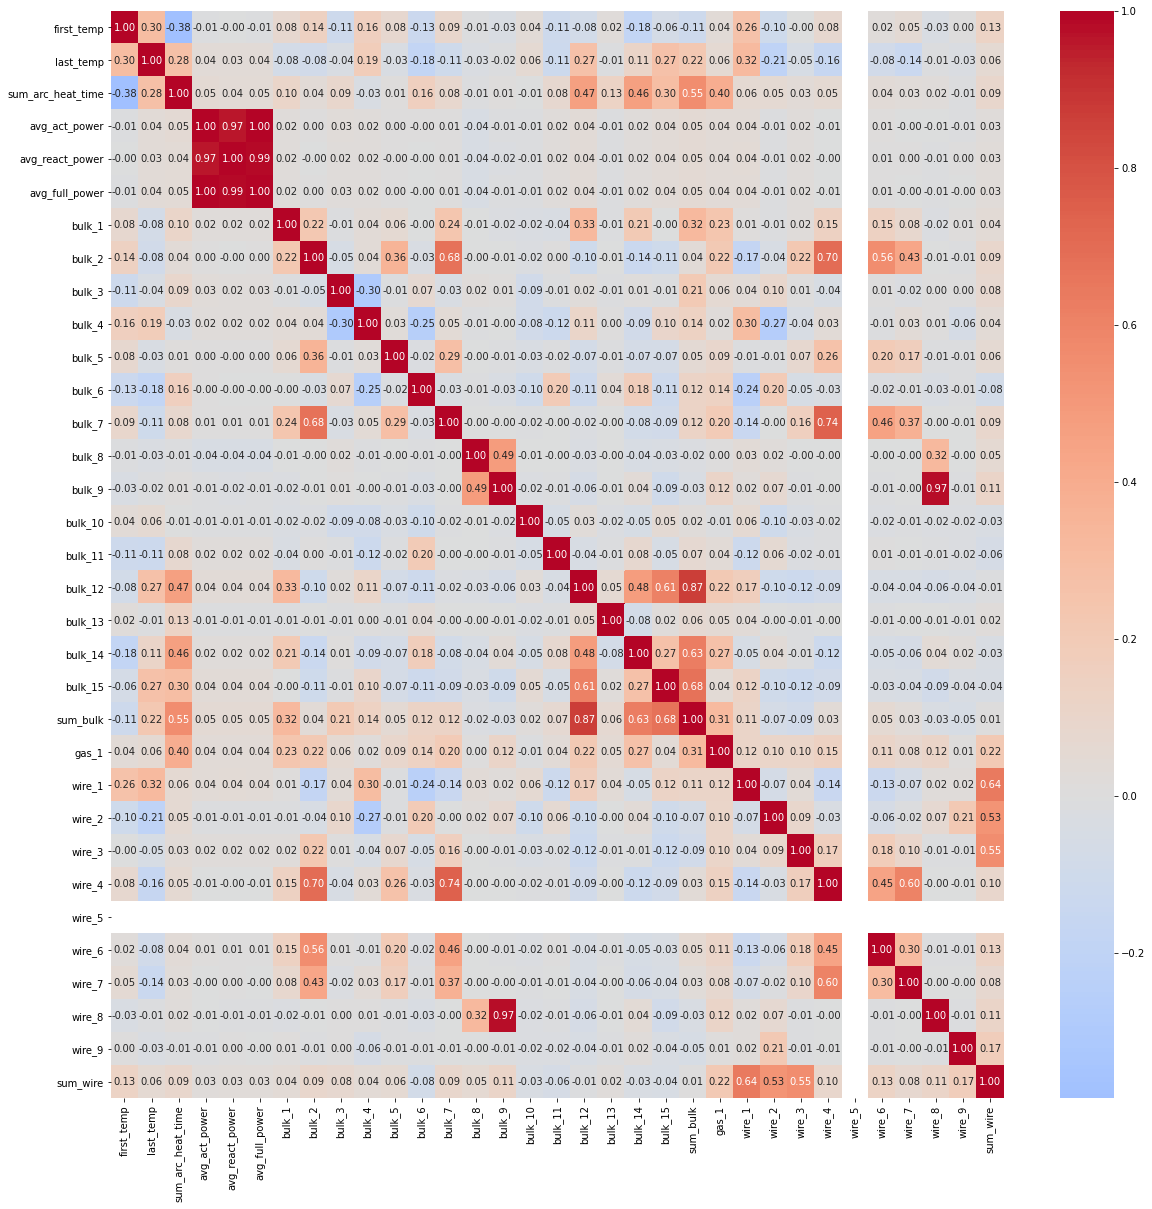

In [118]:
plt.figure(figsize=(20, 20));

sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f'
);

Целевой признак last_temp имеет умеренную корреляцию с первой измеренной температурой, с суммарным временем нагрева электродов, с bulk_12, bulk_15 и sum_bulk, а также с wire_1.

При этом наблюдается мультиколлинеарность между средними значениями мощностей, а также между wire_8 и bulk_9. 

Кроме того, общий объём подаваемых сыпучих веществ высоко коррелирует с bulk_12 и заметно - с суммарным временем нагрева электродов, bulk_14, bulk_15. 

Также присутствует заметная корреляция между общим объёмом подаваемых проволочных материалов и wire_1, wire_2, wire_3. 

Вдобавок, bulk_2 и bulk_7, высоко коррелируя между собой, заметно коррелирует с wire_4, wire_6 и wire_7.

Чтобы избавиться от мультиколлинеарности и оставить в датафрейме только количественные показатели, удалим временные параметры, средние значения активной и реактивной мощностей и wire_8:

In [119]:
df = df.drop(['first_meas_time', 'last_meas_time', 'avg_act_power', 'avg_react_power', 'wire_8'], axis=1)

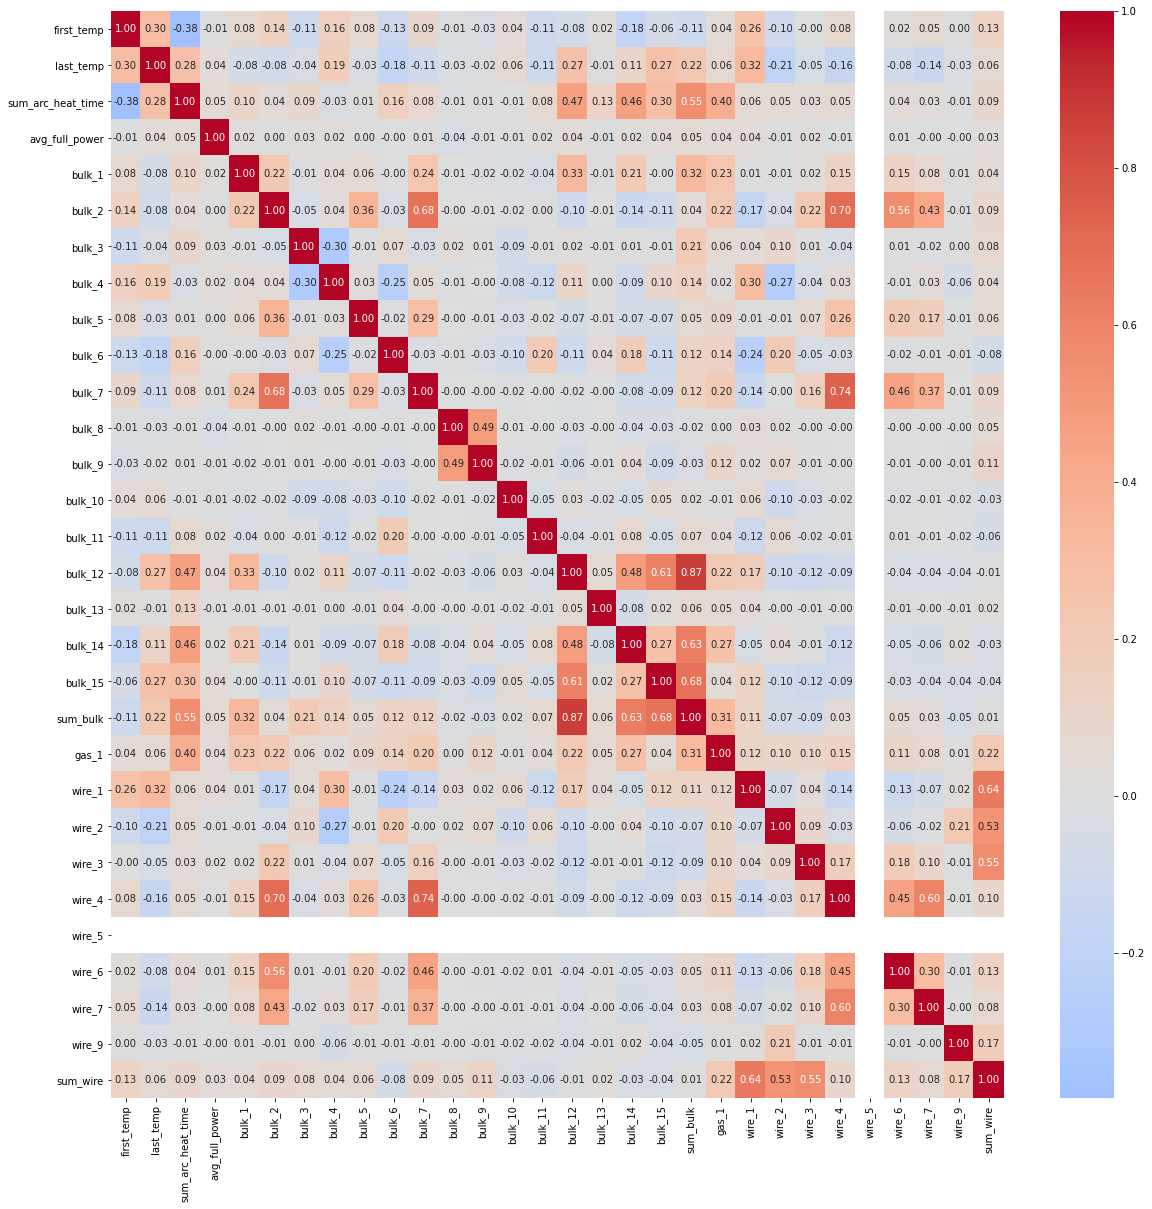

In [120]:
plt.figure(figsize=(20, 20));

sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.2f'
);

***Промежуточный вывод:***

*Таким образом, был проведён корреляционный анализ объединённого датафрейма, в результате которого:*
- мультиколлинеарность была удалена;
- определена корреляция целевого признака last_temp с входными признаками;
- изучена корреляция между входными признаками.

## Подготовка данных


Выполним подготовку данных для обучения модели.

Сначала зададим значение RANDOM_STATE:

In [121]:
# создадим константы RANDOM_STATE И TEST_SIZE:
RANDOM_STATE = 180324
TEST_SIZE = 0.25

Далее выполним следующие действия:
- разобьём данные на тренировочную и тестовую выборки;
- масштабируем количественные признаки с помощью StandardScaler:

In [122]:
# сохраним входные и целевые признаки
X = df.drop(['last_temp'], axis=1)
y = df['last_temp']

# сформируем тренировочную и тестовую выборки
# зафиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [123]:
#выведем размер полученных выборок:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(1746, 29)
(1746,)

(583, 29)
(583,)


In [124]:
# проведём масштабирование признаков:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

***Промежуточный вывод:***

*Таким образом, объединённые данные были разделены на обучающую и тестовую выборки и отмасштабированы методом StandardScaler().*

## Обучение моделей машинного обучения

Перейдём к обучению моделей машинного обучения. Качество моделей будем определять метрикой MAE (mean absolute error): её значение должно быть менее 6.8.

Будем использовать следующие модели:
- LinearRegression без варьирования параметров с кросс-валидацией;
- DecisionTreeRegressor с варьированием параметров;
- CatBoostRegressor (с градиентным бустингом) с варьированием параметров;
- LightGBMRegressor (с градиентным бустингом) с варьированием параметров.

Начнём с модели линейной регрессии:

In [125]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)
        
mae_lr = cross_val_score(
    model_lr,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
).mean()

print('MAE_linear_regression_cv:\n\n', round(-1 * mae_lr, 2))

MAE_linear_regression_cv:

 6.6


Проведём моделирование с помощью DecisionTreeRegressor. Варьирование параметров будем осуществлять с помощью GridSearchCV. Учтём, что для получения положительного значения MAE метрику 'neg_mean_absolute_error' нужно умножить на -1:

In [126]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters_dtr = {
    'min_samples_split': range(2, 8),
    'min_samples_leaf': range(1, 5),
    'max_depth': range(2, 5)
}

# Инициализируем класс для автоматизированного поиска:
# значение кросс-валидации 5, метрика MAE и n_jobs=-1.
gs_dtr = GridSearchCV(
    model_dtr,
    parameters_dtr,
    n_jobs=-1,
    cv=5,
    scoring='neg_mean_absolute_error'
)

gs_dtr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_dtr.best_params_)
print()
print('MAE_decision_tree_regressor_cv:\n\n', round(-1 * gs_dtr.best_score_, 2))

Лучшая модель и её параметры:

 {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}

MAE_decision_tree_regressor_cv:

 7.37


Далее рассмотрим модели градиентного бустинга. Начнём с CatBoostRegressor:

In [127]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False) 

parameters_cbr = {
    'learning_rate': [.1, .5],
    'depth': range(1, 5)
}

gs_cbr = GridSearchCV(
    model_cbr,
    parameters_cbr,
    cv=5,
    scoring='neg_mean_absolute_error'
)

gs_cbr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_cbr.best_params_)
print()
print('MAE_cat_boost_regressor_cv:\n\n', round(-1 * gs_cbr.best_score_, 2))

Лучшая модель и её параметры:

 {'depth': 1, 'learning_rate': 0.1}

MAE_cat_boost_regressor_cv:

 6.4


Вторая модель градиентного бустинга - LightGBMRegressor:

In [128]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE) 

parameters_lgbm = {
    'learning_rate': [.1, .5],
    'num_leaves': [25, 50]
}

gs_lgbm = GridSearchCV(
    model_lgbm,
    parameters_lgbm,
    cv=5,
    scoring='neg_mean_absolute_error'
)

gs_lgbm.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs_lgbm.best_params_)
print()
print('MAE_cat_boost_regressor_cv:\n\n', round(-1 * gs_lgbm.best_score_, 2))

Лучшая модель и её параметры:

 {'learning_rate': 0.1, 'num_leaves': 25}

MAE_cat_boost_regressor_cv:

 6.56


Сделаем проверку на адекватность, сравнив качество предсказаний моделей регрессии с качеством модели, которая предсказывала бы константу. В качестве константной модели используем 'DummyRegressor':

In [129]:
# создание и обучение модели DummyRegressorRegressor 
model_dummy = DummyRegressor(strategy='mean')

model_dummy.fit(X_train, y_train)

# предсказание на кросс-валидации
mae_dummy = cross_val_score(
    model_dummy,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
).mean()

print(f'MAE_dummy_reg_cv: {round(-1 * mae_dummy, 2)}')

MAE_dummy_reg_cv: 8.27


Константная модель показала более худшие результаты, чем применяемые модели регрессии.

Объединим полученные результаты в таблицу:

In [130]:
# объединяем результаты в одну таблицу
result_cv = pd.DataFrame([
    [round(-1 * mae_lr, 2)],
    [round(-1 * gs_dtr.best_score_, 2)],
    [round(-1 * gs_cbr.best_score_, 2)],
    [round(-1 * gs_lgbm.best_score_, 2)],
    [round(-1 * mae_dummy, 2)]
])

result_cv.index = [
    'LinearRegresson',
    'DecisionTreeRegressor',
    'CatBoostRegressor',
    'LightGBMRegressor',
    'DummyRegressor'
]

result_cv.columns = ['MAE_score']

display(result_cv)

,MAE_score
LinearRegresson,6.60
DecisionTreeRegressor,7.37
CatBoostRegressor,6.40
LightGBMRegressor,6.56
DummyRegressor,8.27


***Промежуточный вывод:***

*Таким образом, было выполнено следующее:*
- обучены 4 модели регрессии;
- рассчитанная метрика MAE на кросс-валидации была меньше 6.8 почти для всех применяемых моделей, кроме DecisionTreeRegressor;
- обучены и протестирована константная модель для проверки адекватности применяемых моделей регрессии.

## Выбор лучшей модели

Выберем лучшую модель и проверим её качество на тестовой выборке.

На кросс-валидации лучшие результаты показали модели градиентного бустинга, в особенности CatBoostRegressor, где MAE составил 6.40.

Рассчитаем метрику MAE на тестовой выборке, используя эту модель:

In [131]:
y_pred_cbr= gs_cbr.best_estimator_.predict(X_test)
mae_cbr_test = mean_absolute_error(y_pred_cbr, y_test)

print('MAE_catboost_regressor_test', round(mae_cbr_test, 2))

MAE_catboost_regressor_test 6.1


На тестовой выборке лучшая модель CatBoostRegressor показала значения MAE = 6.1. 

Оценим важность признаков для лучшей модели и с помощью метода SHAP построим график важности и диаграмму вклада признаков в каждое предсказание модели. 

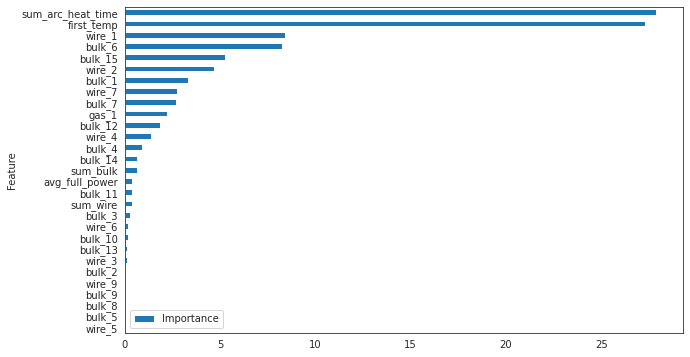

In [132]:
importances = gs_cbr.best_estimator_.feature_importances_

features_names = X_train_scaled.columns

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

sns.set_style('white');
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

Как можно видеть, наибольшую важность при предсказании конечной температуры играют такие признаки, как общее время нагрева электродов и начальная температура. Wire_1, bulk_6, bulk_15, wire_2, bulk_1, wire_7, bulk_7, gas_1, bulk_12 и wire_4 гораздо менее важны. Остальные входные признаки имеют незначительную важность или вовсе неважны для предсказания целевого признака. 

***Промежуточный вывод:***

*Таким образом, наилучшая модель регрессии CatBoostRegressor показала на тестовой выборке значение MAE на уровне 6.1, что является достаточно хорошим показателем. Наиболее важными входными признаками являются общее время нагрева электродов и начальная измеренная температура.*

## Общий вывод и рекомендации заказчику

Сделаем общий вывод о проделанной работе: опишем основные этапы работы, полученные результаты и дадим рекомендации для бизнеса.

**ОБЩИЙ ВЫВОД:**

1. Загрузка данных:

Исходно имелось 7 датафреймов с данными, которые для корректного отображения были загружены с учётом перевода дат в тип 'datetime'.

2. Исследовательский анализ и предобработка данных:

В результате предобработки данных названия столбцов были приведены в соответствие правилам синтаксиса, пропущенные были либо заменены на нули, либо в случае температур удалены, явные дубликаты отсутствовали, а в данные об электродах были добавлены два новых столбца.

В ходе исследовательского анализа данных в датафреймы были добавлены новые столбцы, определён вид распределений количественных значений, из данных об электродах и температурах сформированы таблицы с агрегированными данными. Кроме того, во всех датафреймах столбец с номером партии ('key') был превращен в индексы.

3. Объединение данных:

Общий датафрейм был сформирован методом merge из всех преобразованных и сформированных на предыдущем этапе данных, кроме временных данных.

4. Анализ объединённого датафрейма:

В результате корреляционного анализа объединённого датафрейма была устранена мультиколлинеарность, при этом была определена корреляция между целевым признаком (last_temp) и входными признаками, а также между входными признаками.

5. Подготовка данных:

В ходе подготовки данных для использования моделей машинного обучения объединённый датафрейм был разделён на выборки (обучающую и тестовую) и отмасштабированы.

6. Обучение моделей машинного обучения:

Были обучены и протестированы на кросс-валидации 4 модели регрессии (LinearRegression, DecisionTreeRegressor, CatBoostRegressor и LightGBMRegressor). Для проверки применяемых моделей на адекватность использовалась константная модел DummyRegressor, для котороый метрика MAE на кросс-валидации превысила 8, в отличие от моделей регрессии, где MAE была меньше 6.8 почти во всех случаях, кроме DecisionTreeRegressor. 

7. Выбор лучшей модели:

Наилучшие результаты на кросс-валидации показала модель CatBoostRegressor с MAE = 6.4. Проверка её качества на тестовой выборке дала значение MAE = 6.1.

**РЕКОМЕНДАЦИИ ЗАКАЗЧИКУ:**

С учётом проведённой работы можно сказать, что погрешность предсказания конечной измеренной температуры в 6.1 градуса Цельсия, полученная с помощью модели градиентного бустинга CatBoostRegressor, является достаточно хорошим показателем. Данная модель машинного обучения рекомендуется к внедрению, что позволит с требуемой заказчиком точностью контролировать процесс выплавки стали и экономить электроэнергию.